# Analyzing Links From Russian Trolls
by [Leon Yin](twitter.com/leonyin)<br>
2018-02-20

<a href="https://www.nbcnews.com/tech/social-media/now-available-more-200-000-deleted-russian-troll-tweets-n844731">Link of dataset</a>

In [21]:
import json
import time
import itertools
import requests
from urllib.parse import urlparse

import unshortenit
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [464]:
tweet_url = 'http://nodeassets.nbcnews.com/russian-twitter-trolls/tweets.csv'
df_tweets = pd.read_csv(tweet_url, dtype={'id' : str, 'user_id' : str, 'tweet_id' : str})
df_tweets.drop_duplicates(subset=['tweet_id'], inplace=True)
len(df_tweets)

200631

In [3]:
user_url = 'http://nodeassets.nbcnews.com/russian-twitter-trolls/users.csv'
df_users = pd.read_csv(user_url, dtype={'id' : str})
len(df_users)

453

In [15]:
df_users.head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
0,18710816,near Utah Ave & Lighthouse an,Robby Delaware,304.0,11484.0,Pacific Time (US & Canada),False,en,RobbyDelaware,"I support the free movement of people, ideas a...",Wed Jan 07 04:38:02 +0000 2009,17.0,670.0,13.0
1,100345056,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,1053.0,31858.0,NaN,False,en,SCOTTGOHARD,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,Tue Dec 29 23:15:22 +0000 2009,2774.0,1055.0,35.0
2,247165706,"Chicago, IL",B E C K S T E R✨,650.0,6742.0,Mountain Time (US & Canada),False,en,Beckster319,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,Fri Feb 04 06:38:45 +0000 2011,7273.0,896.0,30.0
3,249538861,NaN,Chris Osborne,44.0,843.0,NaN,False,en,skatewake1994,NaN,Wed Feb 09 07:38:44 +0000 2011,227.0,154.0,1.0
4,449689677,NaN,Рамзан Кадыров,94773.0,10877.0,Moscow,False,ru,KadirovRussia,"Пародийный аккаунт. Озвучиваю то, что политика...",Thu Dec 29 11:31:09 +0000 2011,0.0,7.0,691.0


In [4]:
def get_link(tweet):
    '''
    For pandas!
    Returns a generator containing tweet metadata about media.
    '''
    row = {
        'user.id': tweet['user_id'],
        'tweet.id': tweet['tweet_id'],
        'tweet.created_at': tweet['created_str'],
        'tweet.text' : tweet['text']
    }

    list_urls = tweet['expanded_urls']
    
    if list_urls:
        for url in list_urls:
            r = row.copy()
            r['link.url_long'] = url
            if r['link.url_long']:
                r['link.domain'] = urlparse(r['link.url_long']).netloc.lower()
                yield r  

In [379]:
# load the string into a list, and remove duplcates by casting the list as a set.
df_tweets['expanded_urls'] = df_tweets['expanded_urls'].apply(lambda x : set(json.loads(x)))

In [12]:
for link in get_link(df_tweets.iloc[1]):
    print(link)

{'user.id': '2571870453', 'tweet.id': '785584942356967425', 'tweet.created_at': '2016-10-10 20:57:00', 'tweet.text': 'Clinton: Trump should’ve apologized more, attacked less https://t.co/eJampkoHFZ', 'link.url_long': 'http://detne.ws/2e172jF', 'link.domain': 'detne.ws'}


In [356]:
df_tweets.drop_duplicates(subset=['tweet_id'], inplace=True)

In [381]:
df_links = pd.DataFrame(
    list(
        itertools.chain.from_iterable(
            [ get_link( tweet[1] ) for tweet in tqdm( df_tweets.iterrows() ) if tweet ]
        )
    )
)

A Jupyter Widget

In [382]:
len(df_links)

26628

In [385]:
df_links['tweet.id'].value_counts().head()

775588749929504768    5
777371108131635200    5
776805233230024704    4
775401195368165376    3
775388067792322561    3
Name: tweet.id, dtype: int64

In [389]:
# first 50 shared domains
df_links['link.domain'].value_counts().head(20)

twitter.com               7298
bit.ly                    4442
twibble.io                 945
youtu.be                   472
wapo.st                    465
ln.is                      459
www.breitbart.com          377
dlvr.it                    335
www.youtube.com            305
sh.st                      297
fb.me                      250
ow.ly                      242
goo.gl                     214
www.wcvb.com               210
buff.ly                    198
dailycaller.com            197
hill.cm                    184
on.rt.com                  168
www.huffingtonpost.com     163
www.nytimes.com            163
Name: link.domain, dtype: int64

## Link Analysis <a id="link"></a>
Let's strip all the links out of the tweet.<br>
We can't just return the value, as there can be multiple links per Tweet.<br>
We can solve this by using a generator, and unpacking each using `itertools`.

In [17]:
df_links.head()

,link.domain,link.url_long,tweet.created_at,tweet.id,tweet.text,user.id
0,detne.ws,http://detne.ws/2e172jF,2016-10-10 20:57:00,785584942356967425,"Clinton: Trump should’ve apologized more, atta...",2571870453
1,www.feed24hnews.com,http://www.Feed24hNews.com/4MzaL,2016-10-30 01:48:19,792543622528892929,RT @AriaWilsonGOP: 3 Women Face Charges After ...,1679279490
2,bit.ly,http://bit.ly/2axp6SI,2016-07-27 14:55:39,758314917355106304,Obama on Trump winning: 'Anything's possible' ...,2587843805
3,bgg2wl.com,http://bgg2wl.com/1CDJfQt,2016-10-30 09:29:28,792659678018887685,"RT @bgg2wl: Walmart, Michelle Obama and The Ha...",1660375034
4,twitter.com,https://twitter.com/profchrismjones/status/790...,2016-10-23 03:12:06,790027995343904769,RT @JoyAnnReid: Tried to tell the @amjoyshow s...,1510488662


In [9]:
df_links = df_links[df_links['link.domain'] != 'twitter.com']

In [218]:
# 'ln.is'
'http://ln.is/constitution.com/Qg5CQ'.strip('http://ln.is/')

'constitution.com/Qg5CQ'

In [ ]:
# should I unshorten publication links?

In [ ]:
# twibble.io
# social media manager
# also twib.in

# dlvr.it
# social media manager

# sh.st
# showrens video, hard to expand

In [10]:
import unshortenit

In [159]:
unshortenit.unshorten('http://bit.ly/2axp6SI')

('http://www.kmbc.com/no-longer-available', 200)

In [72]:
df_links[df_links['link.domain'] == 'sh.st'].head()['link.url_long'].values

array(['http://sh.st/8K1C2', 'http://sh.st/7tJuE', 'http://sh.st/5x58h',
       'http://sh.st/4UGEH', 'http://sh.st/4w6gn'], dtype=object)

In [224]:
df_links_[df_links_['link.domain'] == 'ln.is']

,link.domain,link.url_long,tweet.created_at,tweet.id,tweet.text,user.id
86,ln.is,http://ln.is/www.breitbart.com/20/kI3Uc,2016-09-12 17:48:32,775390654306226176,RT @GoldStarMomTX55: ChristiChat: RT LindaSuhl...,1679279490
222,ln.is,http://ln.is/com/mU6Uw,2016-09-18 01:05:05,777312455114559488,RT @apostlelaurinda: &amp;it was a lie = FLASH...,1651693646
271,ln.is,http://ln.is/www.breitbart.com/20/wBmL5,2016-09-19 17:56:11,777929294471368704,"RT @JeffreyGriese: Under Secretary Clinton, U....",2606301939
272,ln.is,http://ln.is/www.breitbart.com/20/wBmL5,2016-09-19 17:56:11,777929294471368704,"RT @JeffreyGriese: Under Secretary Clinton, U....",2606301939
284,ln.is,http://ln.is/rickwells.us/wyZV9,2016-09-17 16:49:31,777187739364159488,RT @karen_erotoo1: Desperate Racist Black Cauc...,2491081213
354,ln.is,http://ln.is/lonestarliberty.org/bWZGJ,2016-09-16 20:42:07,776883889189117952,"RT @jstines3: As The GOP Sinks, The #GOPEXODUS...",1533813962
395,ln.is,http://ln.is/constitution.com/Qg5CQ,2016-10-17 08:20:32,787931284916072448,RT @luvGodncountry: Green Party Candidate Jill...,2535818742
503,ln.is,http://ln.is/www.youtube.com/E88ol,2016-11-07 04:54:34,795489597065220096,RT @ladymacbeth1212: HOMELESS WOMAN WHO PROTEC...,1679279490
504,ln.is,http://ln.is/www.youtube.com/E88ol,2016-11-07 04:54:34,795489597065220096,RT @ladymacbeth1212: HOMELESS WOMAN WHO PROTEC...,1679279490
785,ln.is,http://ln.is/washingtontimes.com/2Pe5L,2016-09-19 21:09:30,777977943800721408,RT @cmdorsey: Judge blasts State Dept. for slo...,1671234620


In [73]:
r = requests.head('http://sh.st/8K1C2', allow_redirects=True)

In [75]:
r.url

'http://sh.st/8K1C2'

Which links will we unshorten?
Lets filter all link domains for the ones in the lists ahove

In [250]:
df_link_match = df_links[df_links['link.domain'].isin(['youtu.be'])]

In [251]:
len(df_link_match)

1353

In [252]:
df_link_match_unique = df_link_match.drop_duplicates(subset=['link.url_long'])

In [253]:
len(df_link_match_unique)

343

In [196]:
df_link_match_unique.to_csv('data/unique_links.csv', index=False)

In [200]:
import time

In [248]:
df_merged[df_merged['link.domain_resolved'] == 'youtube.com'].iloc[118]

link.domain                                                        youtu.be
link.url_long                                 http://youtu.be/zi09VvzZ0Mo?a
tweet.created_at                                        2016-09-11 19:48:13
tweet.id                                                 775058385632845824
tweet.text                RT @TimBartender: Hillary Clinton Collapses at...
user.id                                                          1679279490
link.domain_resolved                                            youtube.com
link.url_long_resolved                        http://youtu.be/zi09VvzZ0Mo?a
Name: 950, dtype: object

In [260]:
# domains for links
general_shorteners = [
    'sh.st',  
]

trouble_shorteners = [
    'dlvr.it', 'bit.ly', 'buff.ly',
    'ow.ly',  'goo.gl', 'shar.es', 
    'ift.tt', 'fb.me',  'washex.am', 'smq.tc',  'trib.al',
    'paper.li', 'waa.ai', 'tinyurl.com',
]

media_shorteners = [
    'on.rt.com', 'wapo.st', 'hill.cm', 'dailym.ai',
    'politi.co', 'fxn.ws', 'usat.ly', 'cnn.it',
    'huff.to', 'nyp.st', 'cbsloc.al', 'nyti.ms',
    'wpo.st', 'on.wsj.com', 'nydn.us', 'youtu.be'
]

shortened_domains = general_shorteners
shortened_domains_2 = media_shorteners + trouble_shorteners
all_short_domains = shortened_domains + shortened_domains_2 + ['ln.is']

def parse_error(row):
    '''
    Parse shortened links that redirect to an invalid address.
    '''
    if 'HTTPConnectionPool' in row:
        vals = row.split("HTTPConnectionPool(host='")[1].split("',")
        domain = vals[0]
        url_endpoint = (vals[1].split('Max retries exceeded with url: ')[-1].
                        split(" (Caused by")[0])
        url_endpoint = os.path.join('http://', domain + url_endpoint)
    else:
        domain, url_endpoint = -1, -1
    
    return domain, url_endpoint

def unshorten(link):
    '''
    Expands shortened urls with different approaches, depending on the shortening service.
    There is no error handling for domains that are not in shortened_domains, or shortened_domains_2.
    '''
    if link['link.domain'] in shortened_domains:
        # expland long link
        url_long, code = unshortenit.unshorten(link['link.url_long'])
        time.sleep(.4)
        domain = urlparse(url_long).netloc.lower()
        
    elif link['link.domain'] in shortened_domains_2:
        try:
            r = requests.head(link['link.url_long'], allow_redirects=True)
            url_long = r.url
            time.sleep(.4)
            domain = urlparse(url_long).netloc.lower()
        
        except requests.exceptions.RequestException as e:
            domain, url_long = parse_error(str(e))
                        
    elif link['link.domain'] == 'ln.is':
        url_long = link['link.url_long'].replace('ln.is/', '')
        time.sleep(.4)
        domain = urlparse(url_long).netloc.lower()
    
    return {'link.domain': link['link.domain'],
            'link.url_long' : link['link.url_long'], 
            'link.domain_resolved' : domain,
            'link.url_long_resolved': url_long}

In [256]:
df_link_match_unique.iloc[100]

link.domain                                                  youtu.be
link.url_long                            https://youtu.be/ASQNDOT6gZA
tweet.created_at                                  2016-10-24 11:18:17
tweet.id                                           790512732269346817
tweet.text          RT @StopStopHillary: Wikileaks  'We have a sur...
user.id                                                    1688370956
Name: 12025, dtype: object

## Notes about error catching

potential catch for 
```HTTPConnectionPool(host='worldlibertynews.com', port=80): Max retries exceeded with url: /is-technology-causing-us-to-evolve-into-a-new-species/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x12b842550>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))```
https://github.com/requests/requests/issues/4147

In [ ]:
# example of an error
"""HTTPConnectionPool(host='worldlibertynews.com', port=80): 
Max retries exceeded with url: /is-technology-causing-us-to-evolve-into-a-new-species/ (Caused by 
NewConnectionError('<urllib3.connection.HTTPConnection object at 0x12b842550>: Failed to establish a new connection:""".

In [22]:
unshorten(df_link_match_unique.iloc[350])

{'link.domain': 'bit.ly',
 'link.domain_resolved': 'www.thedenverchannel.com',
 'link.url_long': 'http://bit.ly/2cXn9yR',
 'link.url_long_resolved': 'https://www.thedenverchannel.com/news/politics/politifact-trump-repeats-false-attack-that-hillary-clinton-was-behind-obama-birther-movement'}

In [261]:
unshorten(df_link_match_unique.iloc[35])

{'link.domain': 'youtu.be',
 'link.domain_resolved': 'www.youtube.com',
 'link.url_long': 'https://youtu.be/l3oqbpl-Ezs',
 'link.url_long_resolved': 'https://www.youtube.com/watch?v=l3oqbpl-Ezs&feature=youtu.be'}

In [92]:
# this is what happens when an error is encountered
parse_error("""HTTPConnectionPool(host='blacktolive.org', port=80): Max retries exceeded with url: /news/white-people-are-ready-to-boycott-nfl-but-not-ready-to-change-anything/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x129e61f60>: Failed to establish a new connection: [Errno 61] Connection refused',))""")

('blacktolive.org',
 'http://blacktolive.org/news/white-people-are-ready-to-boycott-nfl-but-not-ready-to-change-anything/')

Unshorten all the links

In [265]:
unshortened_link_meta = []
with open('data/link_cache_youtube.json', 'w+') as file: 
    for i, row in tqdm(df_link_match_unique.iterrows()):
        if i % 100 == 0:
            print("sleeping")
            time.sleep(15)
        d = unshorten(row)
        unshortened_link_meta.append( d )
        file.write( json.dumps( d ) + '\n' )

A Jupyter Widget

sleeping
sleeping
sleeping
sleeping
sleeping
sleeping



In [390]:
df_link_meta = pd.DataFrame(unshortened_link_meta)

In [392]:
df_link_meta.head()

,link.domain,link.domain_resolved,link.url_long,link.url_long_resolved
0,youtu.be,www.youtube.com,https://youtu.be/y03Sc0H3n8s,https://www.youtube.com/watch?v=y03Sc0H3n8s&fe...
1,youtu.be,www.youtube.com,https://youtu.be/ipH_pPAJDTg,https://www.youtube.com/watch?v=ipH_pPAJDTg&fe...
2,youtu.be,www.youtube.com,https://youtu.be/7rVCWBUJ8Ug,https://www.youtube.com/watch?v=7rVCWBUJ8Ug&fe...
3,youtu.be,www.youtube.com,https://youtu.be/7P4xUWCh7-8,https://www.youtube.com/watch?v=7P4xUWCh7-8&fe...
4,youtu.be,www.youtube.com,https://youtu.be/O0vHZqVn-io,https://www.youtube.com/watch?v=O0vHZqVn-io&fe...


In [118]:
df_resolved = pd.`merge(left=df_links, right=df_link_meta, on=['link.url_long', 'link.domain'])

Analyzing the resolved links.

In [393]:
df_link_meta = pd.read_csv('data/resolved_links_yt_ls.csv')

In [338]:
df_link_meta[df_link_meta['link.domain'] == 'dlvr.it']['link.domain_resolved'].value_counts().head(5)

nydailynews.com     32
rawstory.com        23
foxnews.com         16
bizpacreview.com    14
counterpunch.org    12
Name: link.domain_resolved, dtype: int64

In [339]:
df_link_meta[df_link_meta['link.domain'].isin(general_shorteners + trouble_shorteners + ['ln.is'])]['link.domain_resolved'].value_counts().head(5)

sfgate.com       395
ksnt.com         367
cleveland.com    355
kmbc.com         330
nola.com         237
Name: link.domain_resolved, dtype: int64

In [340]:
df_link_meta['link.domain_resolved'].value_counts().head(5)

washingtonpost.com    475
sfgate.com            395
ksnt.com              367
cleveland.com         355
kmbc.com              330
Name: link.domain_resolved, dtype: int64

In [29]:
# these failed!
df_link_meta[df_link_meta['link.domain_resolved'] == '-1']

,link.domain,link.domain_resolved,link.url_long,link.url_long_resolved
1430,dlvr.it,-1,http://dlvr.it/MHKyRk,-1
1604,ift.tt,-1,http://ift.tt/2eCfkRH,-1
2347,on.rt.com,-1,http://on.rt.com/7rcg,-1
2597,bit.ly,-1,http://bit.ly/2dzRVTA,-1
4793,goo.gl,-1,http://goo.gl/xrd3mx,-1
5111,bit.ly,-1,http://bit.ly/2cvhgsu,-1
5622,fb.me,-1,http://fb.me/5aiYDy6tz,-1
5942,goo.gl,-1,http://goo.gl/fb/kvNWQ9,-1
7509,fb.me,-1,http://fb.me/1wvYf2bMU,-1


In [394]:
def remove_www(site_str):
    '''
    Best attempt to standardize websites.
    '''
    return site_str.replace('www.', '').replace('http://', '').replace('https://', '').rstrip('/')

df_link_meta['link.domain_resolved'] = df_link_meta['link.domain_resolved'].apply(remove_www)

In [398]:
def fill_resolved(row):
    if (not row['link.domain_resolved'] or 
       pd.isnull(row['link.domain_resolved']) or
       row['link.domain_resolved'] == '-1'):
                
        return row['link.domain'], row['link.url_long']
    else:
        return row['link.domain_resolved'], row['link.url_long_resolved']

df_merged = df_links.merge(df_link_meta, on =['link.url_long', 'link.domain'], how='left')    

(df_merged['link.domain_resolved'], 
 df_merged['link.url_long_resolved']) = zip(*df_merged.apply(fill_resolved, axis=1))

df_merged['link.domain_resolved'] = df_merged['link.domain_resolved'].replace({'youtu.be': 'www.youtube.com'})
df_merged['link.domain_resolved'] = df_merged['link.domain_resolved'].apply(remove_www)

In [407]:
df_merged['link.domain_resolved'].value_counts().head(21)

twitter.com             7329
twibble.io               945
youtube.com              927
breitbart.com            691
washingtonpost.com       627
sfgate.com               396
ksnt.com                 388
cleveland.com            364
kmbc.com                 331
dailycaller.com          313
thehill.com              304
reuters.com              277
truthfeed.com            247
nola.com                 240
thegatewaypundit.com     239
nytimes.com              233
huffingtonpost.com       226
foxnews.com              223
ksn.com                  216
politico.com             214
wcvb.com                 210
Name: link.domain_resolved, dtype: int64

In [395]:
df_os['domain'] = df_os['domain'].apply(remove_www)

## Youtube

In [400]:
df_yt = df_merged[df_merged['link.domain_resolved'] == 'youtube.com']

In [401]:
len(df_yt)

927

In [402]:
def get_video_link(row):
    url = row['link.url_long_resolved'].split('/')[-1]
    return url.split('&')[0].replace('watch?v=', '')

In [403]:
df_yt['id'] = df_yt.apply(get_video_link, axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [414]:
video_lookups = {'_rWS9w9cEOg' : 'Black Church Endorses Donald Trump For President. The Reasons Why May Shock You',
'X4UDYWn9ezI' : 'BOMBSHELL: THE CLINTON CARTEL EXPOSED Pt.1',
'phKO2T2pMjM' : 'Haitian President EXPOSES t...',
'2_5b98GrlPE' : 'Trump About You',
'cQcd41RO25k' : 'Barack Obama Admits he was born in Kenya Speech',
'VmFiVuSednc ':'PROOF HILLARY IS UNFIT TO HOLD OFFICE',
'5IuJGHuIkzY ':'Rigging the Election - Video I: Clinton Campaign and DNC Incite Violence at Trump Rallies',
 'hDc8PVCvfKs':'Rigging the Election - Video II: Mass Voter Fraud',
 'Z0GFRcFm-aY' : "R.E.M. - It's The End Of The World",
'8tm9XMrio98' : 'The Truth About the New York Bombing',
                'dSRDntCk0rA' : "Obama's new role",
          'boMDr6d-EgQ'  :'Act Out! [77] - The Real Election Spoilers and We Pledge Allegiance to Knowledge'}

In [405]:
df_yt['id'].value_counts().head()

2_5b98GrlPE    66
phKO2T2pMjM    17
hDc8PVCvfKs     8
8RI2kN0xBsU     7
8tm9XMrio98     6
Name: id, dtype: int64

## Questionable Media Domains <a id="fake"></a>
We can use the open sources dataset to filter domains on various criteria.<br>
Here is a <a href="https://nbviewer.jupyter.org/github/yinleon/fake_news/blob/master/opensources-lite.ipynb">notebook</a> that makes the data machine-readible.

In [31]:
opensorces_clean_url = 'https://raw.githubusercontent.com/yinleon/fake_news/master/data/sources_clean.tsv'
df_os = pd.read_csv(opensorces_clean_url, sep='\t')
len(df_os)

825

In [32]:
df_os['domain'] = df_os['domain'].apply(remove_www)
df_os.head()

,domain,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,state,unreliable,notes
0,100percentfedup.com,1,0,0,0,0,0,0,0,0,0,0,0,NaN
1,16wmpo.com,0,0,0,1,0,0,0,0,0,0,0,0,http://www.politifact.com/punditfact/article/2...
2,21stcenturywire.com,0,0,1,0,0,0,0,0,0,0,0,0,NaN
3,24newsflash.com,0,0,0,1,0,0,0,0,0,0,0,0,NaN
4,24wpn.com,0,0,0,1,0,0,0,0,0,0,0,0,http://www.politifact.com/punditfact/article/2...


In [33]:
# this is what infowars shows up as...
df_os[df_os['domain'] == 'infowars.com']

,domain,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,state,unreliable,notes
384,infowars.com,0,0,1,0,0,0,0,0,0,0,0,0,NaN


In [419]:
df_questionable = pd.merge(left= df_merged, left_on= 'link.domain_resolved', 
                           right= df_os, right_on= 'domain', how= 'left')

In [420]:
df_questionable['tweet.created_at'] = pd.to_datetime(df_questionable['tweet.created_at'])

In [421]:
%matplotlib inline
import datetime

In [422]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

What is the breakdown of links shared from questionable sites?

We can do some simple matrix math to see the breakdown of quesitonable links

In [423]:
# these are the columns we'll base out calculations on.
media_classes = [c for c in df_os.columns if c not in ['domain', 'notes']]
breakdown = df_questionable[media_classes].sum(axis=0)
breakdown.sort_values(ascending=False)

bias          2796.0
political     1702.0
unreliable    1676.0
clickbait     1040.0
conspiracy    1017.0
hate           382.0
fake           280.0
state          203.0
rumor           49.0
junksci         33.0
satire          24.0
reliable        22.0
dtype: float64

In [44]:
# these are the columns we'll base out calculations on. NOT STANDARDIZING DOMAINS
media_classes = [c for c in df_os.columns if c not in ['domain', 'notes']]
breakdown = df_questionable[media_classes].sum(axis=0)
breakdown

bias          1159.0
clickbait      574.0
conspiracy     408.0
fake           157.0
hate           227.0
junksci         35.0
political      627.0
reliable        18.0
rumor           25.0
satire           6.0
state           13.0
unreliable     341.0
dtype: float64

In [45]:
%matplotlib inline

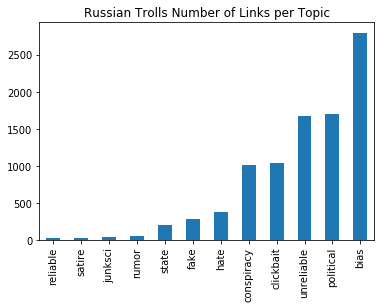

In [424]:
# correct joining
breakdown[breakdown != 0].sort_values().plot(
    kind='bar', title='Russian Trolls Number of Links per Topic'
)

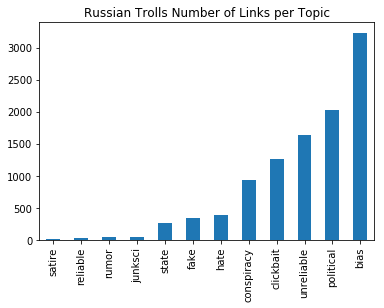

In [114]:
# # we'll filter out the non-represented classes, sort them, and plot it!
# breakdown[breakdown != 0].sort_values().plot(
#     kind='bar', title='Russian Trolls Number of Links per Topic'
# )

One hot encode all domains

In [115]:
df_dumb = pd.get_dummies(df_questionable, columns=['link.domain_resolved'], 
                         prefix='link_latent_')

In [116]:
vc = df_questionable['link.domain_resolved'].value_counts()
vc

youtu.be                                       1355
twibble.io                                      945
breitbart.com                                   608
www.youtube.com                                 591
www.breitbart.com                               576
washingtonpost.com                              569
dailycaller.com                                 552
thehill.com                                     398
sfgate.com                                      395
ksnt.com                                        390
cleveland.com                                   361
youtube.com                                     348
kmbc.com                                        330
www.frontpagemag.com                            309
truthfeed.com                                   308
rt.com                                          250
nola.com                                        237
www.huffingtonpost.com                          226
americanthinker.com                             222
reuters.com 

In [117]:
# all domains shared over 4 times
sites = vc[vc > 4].index.tolist()

In [118]:
dumb_cols = [c for c in df_dumb.columns if 'link_latent' in c and any(x in c for x in sites)]

In [119]:
one_hot_domains = df_dumb.groupby('user.id')[dumb_cols].sum()

In [120]:
def normalize(row):
    return row / row.sum()

In [121]:
one_hot_domains = one_hot_domains.apply(normalize)

In [122]:
one_hot_domains.head()

,link_latent__100percentfedup.com,link_latent__1776coalition.com,link_latent__21stcenturywire.com,link_latent__2dopeboyz.com,link_latent__2ndamendmentfight.com,link_latent__3chicspolitico.com,link_latent__3tags.org,link_latent__4.nbcla.com,link_latent__4votingrights.com,link_latent__53eig.ht,...,link_latent__youcaring.com,link_latent__youngcons.com,link_latent__yourblackworld.net,link_latent__yournewswire.com,link_latent__youtu.be,link_latent__youtube.com,link_latent__ytaclub.com,link_latent__zerohedge.com,link_latent__zite.to,link_latent__zombietime.com
user.id,,,,,,,,,,,,,,,,,,,,,
100345056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.002952,0.0,0.0,0.0,0.0,0.0
1039581360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1497280638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1504356343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1510488662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [425]:
one_hot_domains_questionable = df_questionable.groupby('user.id')[media_classes].sum().fillna(0)
one_hot_domains_questionable = one_hot_domains_questionable.apply(normalize, axis=1).fillna(0)

In [174]:
from sklearn.manifold import TSNE

In [426]:
tsne = TSNE(n_components=2, learning_rate=150, verbose=2).fit_transform(one_hot_domains_questionable)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 343 samples in 0.001s...
[t-SNE] Computed neighbors for 343 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 343 / 343
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.023s
[t-SNE] Iteration 50: error = 50.7911987, gradient norm = 0.5897917 (50 iterations in 0.415s)
[t-SNE] Iteration 100: error = 50.0122414, gradient norm = 0.5727629 (50 iterations in 0.397s)
[t-SNE] Iteration 150: error = 50.4989662, gradient norm = 0.5605522 (50 iterations in 0.426s)
[t-SNE] Iteration 200: error = 50.9301529, gradient norm = 0.5650368 (50 iterations in 0.390s)
[t-SNE] Iteration 250: error = 49.6658173, gradient norm = 0.5890091 (50 iterations in 0.440s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.665817
[t-SNE] Iteration 300: error = 0.3326319, gradient norm = 0.0018072 (50 iterations in 0.360s)
[t-SNE] Iteration 350: error = 0.3192607, gradient norm = 0.0002671 (

In [427]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

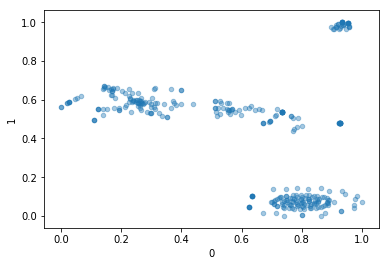

In [428]:
pd.DataFrame(list(zip(tx,ty))).plot.scatter(
    x=0, y=1, alpha = .4)

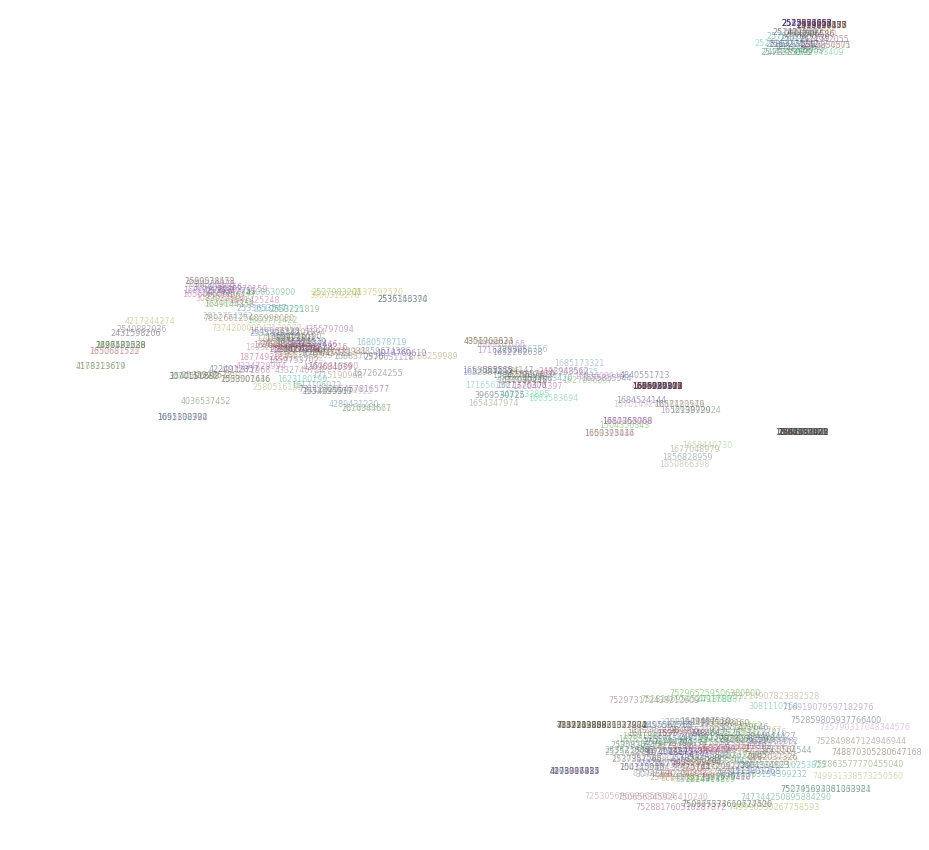

In [429]:
d1, d2 = 0, 1

dat = tsne
plt.figure(figsize=(15,15))
for label, x, y in zip(one_hot_domains_questionable.index.values, dat[:, d1], dat[:, d2]):
    plt.text(x, y, label, color=np.random.rand(3)*0.7,
             fontsize=8, alpha = .4)

x_min, x_max = dat[:, 0].min() - 1, dat[:, 0].max() + 1
y_min, y_max = dat[:, 1].min() - 1, dat[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.axis('off')
plt.show();

# Temporal

In [430]:
import matplotlib.pyplot as plt

In [431]:
dat1 = (df_questionable[(df_questionable['domain'].isnull()) 
                      & (df_questionable['tweet.created_at'] >= datetime.datetime(2016,6,1) )]
 ['tweet.created_at'].dt.date.value_counts()
).reset_index()

dat2 = (df_questionable[ (~df_questionable['domain'].isnull()) 
                       & (df_questionable['tweet.created_at'] >= datetime.datetime(2016,6,1) )]
 ['tweet.created_at'].dt.date.value_counts()).reset_index()

dat1.sort_values(by='index', inplace=True)
dat2.sort_values(by='index', inplace=True)

merge = dat1.merge(dat2, on='index', how='outer')

def ratio(row):
    return row['tweet.created_at_y'] / row['tweet.created_at_x'] 

merge['ratio'] = merge.apply(ratio, axis=1)

In [432]:
merge['index'] = pd.to_datetime(merge['index'])
merge_ = merge[(~merge['ratio'].isnull()) & 
               (merge['index'] >= datetime.datetime(2016,7,17))]

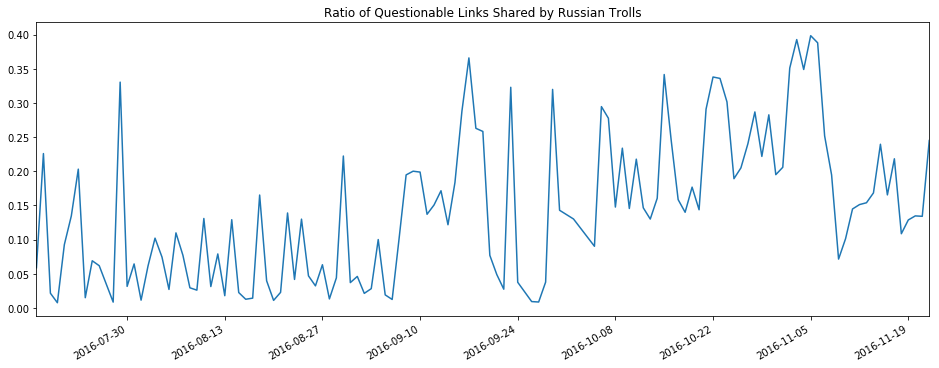

In [433]:
ax = merge_.plot(x='index', y='ratio', legend=False, 
                 title='Ratio of Questionable Links Shared by Russian Trolls',
                 figsize=(16,6))
ax.xaxis.label.set_visible(False)
fig = ax.get_figure()
# fig.savefig('figs/ratio_questionable.png');

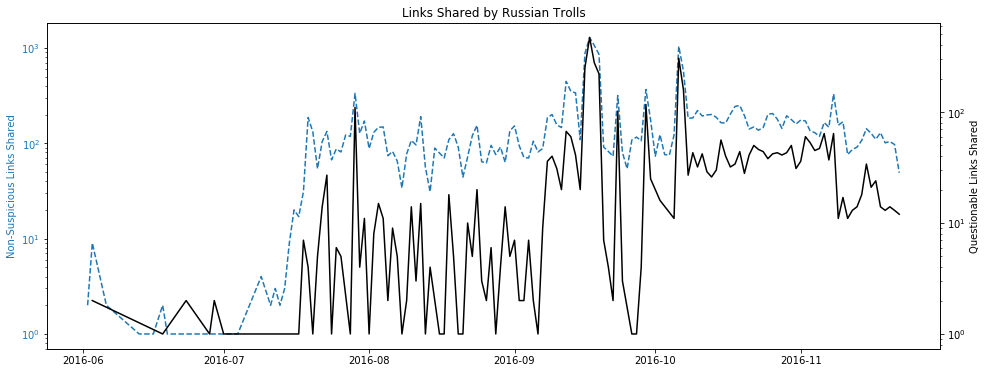

In [467]:
x1, y1 = dat1['index'], dat1['tweet.created_at']
x2, y2 = dat2['index'], dat2['tweet.created_at']

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(111)
ax1.plot(x1, y1, '--')
ax1.set_ylabel('Non-Suspicious Links Shared', color='C0')

ax2 = ax1.twinx()
ax2.plot(x2, y2, color='k')
ax2.set_ylabel('Questionable Links Shared')
for tl in ax1.get_yticklabels():
    tl.set_color('C0')
ax1.set_yscale('log')
ax2.set_yscale('log')

plt.title("Links Shared by Russian Trolls")
# plt.savefig('figs/links_shared.png')

In [468]:
spearmanr(merge_['tweet.created_at_x'], merge_['tweet.created_at_y'])

SpearmanrResult(correlation=0.8034752512822098, pvalue=2.965984927173917e-29)

In [189]:
usnpl_clean_url = 'https://raw.githubusercontent.com/yinleon/usnpl/master/data/usnpl_newspapers_twitter_ids.csv'
df_usnpl = pd.read_csv(usnpl_clean_url)
len(df_usnpl)

6221

In [190]:
df_usnpl['Website'] = df_usnpl['Website'].apply(remove_www)
df_usnpl_one_hot = pd.get_dummies(df_usnpl[['Website', 'Medium']], columns=['Medium'])

In [208]:
remap = {
    'Website' : 'domain',
    'Medium' : 'state_level_media',
    'Geography' : 'state'
}

remap_vals = {
    'Newspapers' : 'newspaper',
    'College Newspapers' : 'college_newspaper',
    'Magazines' : 'magazine'
}

In [209]:
df_usnpl.columns = [remap.get(c,c) for c in df_usnpl.columns]

In [206]:
df_usnpl['state_level_media'] = df_usnpl['state_level_media'].replace(remap_vals)

In [457]:
df_usnpl_one_hot = pd.get_dummies(df_usnpl[['domain', 'state_level_media']], columns=['state_level_media'])

In [458]:
df_questionable_2 = pd.merge(left= df_questionable, left_on= 'link.domain_resolved', 
                             right= df_usnpl_one_hot, right_on= 'domain', how= 'left')

In [469]:
df_questionable_2.head()

,link.domain,link.url_long,tweet.created_at,tweet.id,tweet.text,user.id,link.domain_resolved,link.url_long_resolved,domain_x,bias,...,reliable,rumor,satire,state,unreliable,notes,domain_y,state_level_media_college_newspaper,state_level_media_magazine,state_level_media_newspaper
0,ln.is,http://ln.is/twitchy.com/loriz-31/3yafU,2016-09-18 19:46:25,777594647875059712,RT @NahBabyNah: Twitchy: Chuck Todd caught out...,1694026190,twitchy.com,http://twitchy.com/loriz-31/3yafU,twitchy.com,0.0,...,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,twitter.com,https://twitter.com/i/web/status/7824086613898...,2016-10-02 02:35:35,782408661389840384,"@NickTomaWBRE Hi, Nick! We're holding a ""Miner...",737420000043139072,twitter.com,https://twitter.com/i/web/status/7824086613898...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,freedomoutpost.com,http://freedomoutpost.com/2013/02/the-use-of-r...,2016-09-19 13:20:08,777859822679158784,"RT @leonpui_: Hillary Clinton, Obama and the D...",1649967228,freedomoutpost.com,http://freedomoutpost.com/2013/02/the-use-of-r...,freedomoutpost.com,1.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,www.informationliberation.com,http://www.informationliberation.com/?id=55568,2016-09-30 23:29:54,781999544502521857,RT @PrisonPlanet: Hillary's anti-Trump poster ...,2606301939,informationliberation.com,http://www.informationliberation.com/?id=55568,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,twitter.com,https://twitter.com/Harlan/status/777145809695...,2016-09-17 20:09:42,777238119166775297,"RT @American_Woman4: #MAGA,#FEMININEAMERICA4TR...",1679279490,twitter.com,https://twitter.com/Harlan/status/777145809695...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [459]:
cols = df_os.columns.tolist() + df_usnpl_one_hot.columns.tolist()
# these are the columns we'll base out calculations on.
media_classes = [c for c in cols if c not in ['domain', 'notes']]
breakdown = df_questionable_2[media_classes].sum(axis=0)
breakdown.sort_values(ascending=False)

state_level_media_newspaper            3125.0
bias                                   2796.0
political                              1702.0
unreliable                             1676.0
clickbait                              1040.0
conspiracy                             1017.0
hate                                    382.0
fake                                    280.0
state                                   203.0
rumor                                    49.0
state_level_media_magazine               34.0
junksci                                  33.0
satire                                   24.0
reliable                                 22.0
state_level_media_college_newspaper       1.0
dtype: float64

In [460]:
one_hot_domains_questionable = df_questionable_2.groupby('user.id')[media_classes].sum().fillna(0)
one_hot_domains_questionable = one_hot_domains_questionable.apply(normalize, axis=1).fillna(0)

tsne = TSNE(n_components=2, learning_rate=150, verbose=2).fit_transform(one_hot_domains_questionable)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 343 samples in 0.000s...
[t-SNE] Computed neighbors for 343 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 343 / 343
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.022s
[t-SNE] Iteration 50: error = 49.7018929, gradient norm = 0.5856484 (50 iterations in 0.382s)
[t-SNE] Iteration 100: error = 48.2024689, gradient norm = 0.6057478 (50 iterations in 0.364s)
[t-SNE] Iteration 150: error = 49.6749725, gradient norm = 0.5609922 (50 iterations in 0.380s)
[t-SNE] Iteration 200: error = 48.6124611, gradient norm = 0.5810230 (50 iterations in 0.350s)
[t-SNE] Iteration 250: error = 49.8023186, gradient norm = 0.5570140 (50 iterations in 0.375s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.802319
[t-SNE] Iteration 300: error = 0.3162048, gradient norm = 0.0017687 (50 iterations in 0.316s)
[t-SNE] Iteration 350: error = 0.3009621, gradient norm = 0.0003295 (

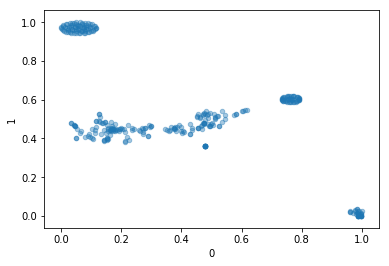

In [461]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

pd.DataFrame(list(zip(tx,ty))).plot.scatter(
    x=0, y=1, alpha = .4)

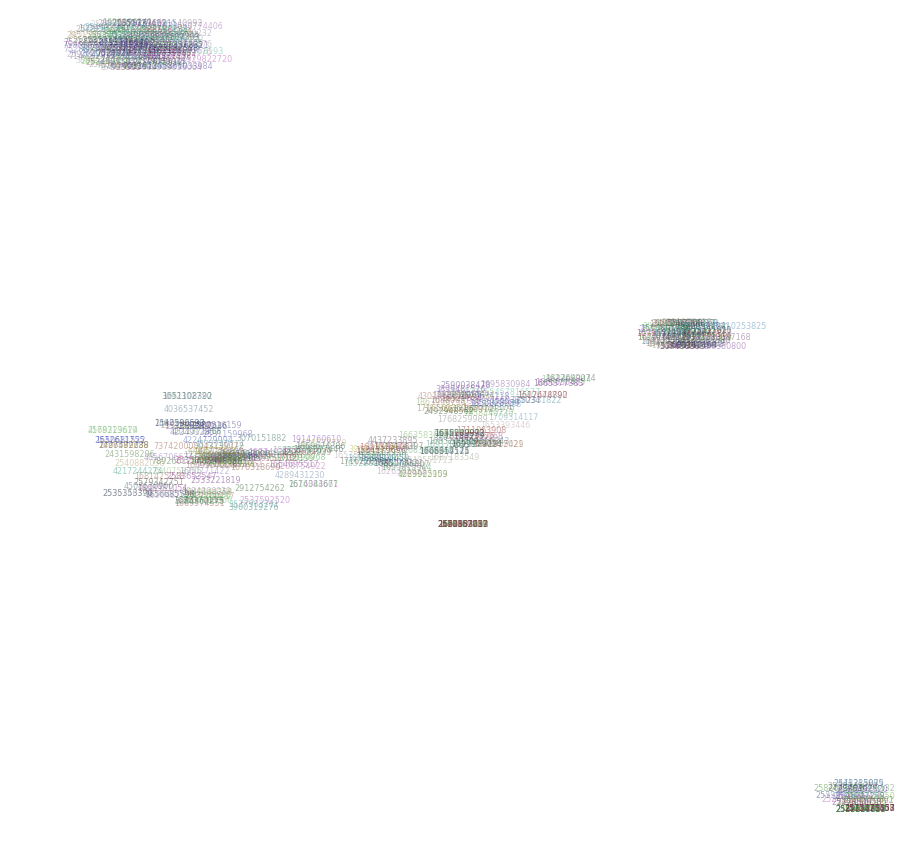

In [463]:
d1, d2 = 0, 1

dat = tsne
plt.figure(figsize=(15,15))
for label, x, y in zip(one_hot_domains_questionable.index.values, dat[:, d1], dat[:, d2]):
    plt.text(x, y, label, color=np.random.rand(3)*0.7,
             fontsize=8, alpha = .4)

x_min, x_max = dat[:, 0].min() - 1, dat[:, 0].max() + 1
y_min, y_max = dat[:, 1].min() - 1, dat[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.axis('off')
plt.show();

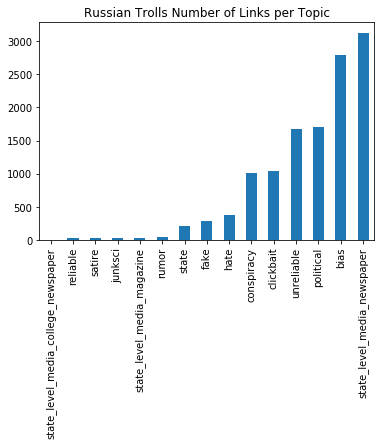

In [462]:
# correct joining
breakdown[breakdown != 0].sort_values().plot(
    kind='bar', title='Russian Trolls Number of Links per Topic'
)

In [444]:
df_usnpl_one_hot_state = pd.get_dummies(df_usnpl[['domain', 'state_level_media', 'state']], columns=['state'])

In [447]:
df_questionable_3 = pd.merge(left= df_questionable, left_on= 'link.domain_resolved', 
                             right= df_usnpl_one_hot_state, right_on= 'domain', how= 'left')

In [449]:
cols = df_os.columns.tolist() + df_usnpl_one_hot_state.columns.tolist()
# these are the columns we'll base out calculations on.
media_classes = [c for c in cols if c not in ['domain', 'notes']]
breakdown = df_questionable_3[media_classes].sum(axis=0)
breakdown.sort_values(ascending=False).head(20)

bias          2796.0
political     1702.0
unreliable    1676.0
state_DC      1413.0
clickbait     1040.0
conspiracy    1017.0
state_NY       620.0
hate           382.0
fake           280.0
state          203.0
state_NJ       189.0
state_VA       154.0
state_TX       145.0
state_AZ       139.0
state_CA       117.0
state_IL        67.0
state_MO        66.0
state_MI        59.0
rumor           49.0
state_PA        44.0
dtype: float64

In [450]:
one_hot_domains_questionable = df_questionable_3.groupby('user.id')[media_classes].sum().fillna(0)
one_hot_domains_questionable = one_hot_domains_questionable.apply(normalize, axis=1).fillna(0)

tsne = TSNE(n_components=2, learning_rate=150, verbose=2).fit_transform(one_hot_domains_questionable)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 343 samples in 0.001s...
[t-SNE] Computed neighbors for 343 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 343 / 343
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.023s
[t-SNE] Iteration 50: error = 53.8615456, gradient norm = 0.5651188 (50 iterations in 0.472s)
[t-SNE] Iteration 100: error = 53.9107666, gradient norm = 0.5786546 (50 iterations in 0.435s)
[t-SNE] Iteration 150: error = 56.0051346, gradient norm = 0.5726314 (50 iterations in 0.483s)
[t-SNE] Iteration 200: error = 54.3675957, gradient norm = 0.5751335 (50 iterations in 0.480s)
[t-SNE] Iteration 250: error = 54.7553596, gradient norm = 0.5620599 (50 iterations in 0.438s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.755360
[t-SNE] Iteration 300: error = 0.3978505, gradient norm = 0.0024864 (50 iterations in 0.382s)
[t-SNE] Iteration 350: error = 0.3884825, gradient norm = 0.0004062 (

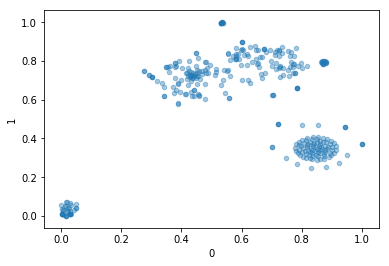

In [451]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

pd.DataFrame(list(zip(tx,ty))).plot.scatter(
    x=0, y=1, alpha = .4)

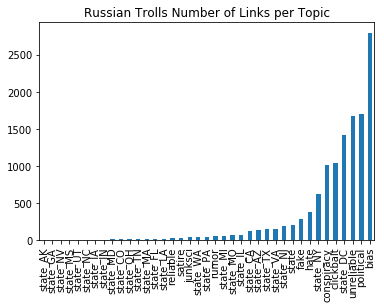

In [452]:
# correct joining
breakdown[breakdown != 0].sort_values().plot(
    kind='bar', title='Russian Trolls Number of Links per Topic'
)